In [10]:
import haiku as hk
import jax
import jax.numpy as jnp
import functools
import numpy as np
import optax
import tqdm
import tree
import pandas as pd
import matplotlib.pyplot as plt

from absl import logging
from typing import Any

from data import utm_data_generator as utm_dg_lib
from data import chomsky_data_generator as chomsky_sampler_lib
from helpers import make_chomsky_generator, utm_data_generator, make_model, init_params, save_params, evaluate_transformer_decoder, CHOMSKY_ALPHABET_SIZE

In [17]:
seed = 1

# Follows the paper's parameters
TRAINING_STEPS = 2000
EXECUTION_STEPS = 1000
USE_DELIMITERS = True
MEMORY_SIZE = 200
BATCH_SIZE = 32

# Use Markov = [True, False]
USE_MARKOV = True
# Model Size = ["small", "medium", "large"]
MODEL_SIZE = "large"

In [18]:
def _make_loss_fn(model: hk.Transformed) -> Any:
  """Returns the loss function for update_parameters."""

  def loss_fn(
      params: hk.Params,
      sequences: jax.Array,
      mask: jax.Array,
  ) -> jnp.float32:
    """Returns the loss for the model and the last state.

    Args:
      params: The parameters of the model, usually a neural network.
      sequences: The input of sequences to evaluate. See neural_predictors.py.
      mask: A binary array, True (1's) denote where to skip computing the loss.
    """
    # This code computes the loss for a transformer decoder model:
    # 1. Apply the model to get log probabilities (conditionals) for each token
    conditionals = model.apply(
        params=params,
        targets=sequences,
        rng=None,
    )
    # 2. Extract the log probabilities of the actual tokens that appeared in the sequence
    # by using take_along_axis to select the probability corresponding to each token
    true_conditionals = jnp.take_along_axis(
        conditionals, sequences[..., None], axis=-1
    )[..., 0]
    # 3. Apply the mask to zero out log probabilities where we should skip computing loss (e.g., for padding tokens)
    true_conditionals = jnp.where(mask, 0.0, true_conditionals)
    # 4. Sum the log probabilities across the sequence dimension to get log likelihood per batch
    marginals = jnp.sum(true_conditionals, axis=1)  # Shape (B,).
    # 5. Return the negative mean log likelihood as the loss (for minimization)
    return -jnp.mean(marginals)

  return loss_fn


@functools.partial(
    jax.jit, static_argnames=('optimizer', 'grad_fn', 'normalize_gradients')
)
def _update_parameters(
    params: hk.Params,
    opt_state: optax.OptState,
    sequences: jax.Array,
    mask: jax.Array,
    grad_fn: Any,
    optimizer: optax.GradientTransformation,
    normalize_gradients: bool = True,
) -> tuple[hk.Params, optax.OptState, dict[str, Any]]:
  """Returns updated params and extra logs (like loss, last state etc).

  Backpropagation is done on the whole sequence. The whole function is jitted.

  Args:
    params: The current parameters of the network.
    opt_state: The optimizer state.
    sequences: The input of sequences to evaluate. See base_predictor.py.
    mask: A binary array, True (1's) denote where to skip computing the loss.
    grad_fn: A gradient function, which takes some parameters, a random seed,
      the data to compute the gradient on, and an initial state for the
      predictor. It returns the gradient of the parameters for this batch of
      data, and extra values.
    optimizer: An optax optimizer.
    normalize_gradients: Whether to divide the gradients by the length of the
      sequences, or keep them as is. Using this option guarantees to have the
      same scale across various sequence lengths, and therefore tasks.
  """
  loss, grad = grad_fn(params, sequences, mask)
  if normalize_gradients:
    length_sequence = float(sequences.shape[1])
    grad = tree.map_structure(lambda x: x / length_sequence, grad)
  updates, new_opt_state = optimizer.update(grad, opt_state)
  new_params = optax.apply_updates(params, updates)

  log_dict = {
      'loss': loss,
      'grad_norm_unclipped': optax.global_norm(grad),
  }

  return new_params, new_opt_state, log_dict

In [19]:
def train_transformer_decoder(
    data_generator: utm_dg_lib.UTMDataGenerator,
    training_steps: int,
    log_every: int,
    batch_size: int,
    use_tqdm: bool = True,
    with_markov: bool = False,
    size: str = "large",
    eval_data_generator: chomsky_sampler_lib.ChomskyDataGenerator = None,
) -> tuple[hk.Params, float, list[float], list[float], list[float]]:
    """Trains a neural network on some synthetic data.

    We train a decoder-only transformer on batches, minimizing the log-loss
    objective. The exact architecture can be modified using the TransformerConfig
    object (defined in models/transformer.py)

    Args:
      data_generator: Used to generate batches of data to train on.
      training_steps: Number of batches to train on.
      log_every: How often to log the loss. If negative or 0, no log at all.
      batch_size: The number of sequences in a batch.
      use_tqdm: Whether to use a progress bar or not.

    Returns:
      The final loss, and final parameters.
    """
    print("Vocab Size:", data_generator.feature_size)
    print("Model Size:", size)
    print("Batch Size:", batch_size)
    print("With Markov:", with_markov)
    model = make_model(data_generator, size)

    params = init_params(model, data_generator, batch_size)

    # Make gradient function.
    loss_fn = _make_loss_fn(model)
    grad_fn = jax.value_and_grad(loss_fn, has_aux=False)

    # Make optimizer, to apply the gradients.
    optimizer = optax.adam(learning_rate=1e-4)
    opt_state = optimizer.init(params)

    logging.info("Initialization done, starting training...")
    
    last_loss = 0.0
    default_mask = lambda x: np.ones(x.shape[:2], dtype=bool)
    eval_losses = []
    eval_accs = []
    eval_final_accs = []

    for step in tqdm.trange(training_steps, disable=not use_tqdm):
        batch, log_dict = data_generator.sample(with_markov=with_markov)
        # Transform one-hots to integer tokens.
        batch = np.argmax(batch, axis=-1)
        if "loss_mask" in log_dict:
            loss_mask = log_dict["loss_mask"]
        else:
            loss_mask = default_mask(batch)

        params, opt_state, logs = _update_parameters(
            params=params,
            opt_state=opt_state,
            sequences=batch,
            grad_fn=grad_fn,
            optimizer=optimizer,
            mask=loss_mask,
        )
        
        if log_every > 0 and step % log_every == 0:
            logging.info(
                "Step %d, Loss (avg cumulative nats) %f, Grad norm %f",
                step,
                logs["loss"],
                logs["grad_norm_unclipped"],
            )
        
        if step % (log_every * 10) == 0 and eval_data_generator is not None:
            last_loss = logs["loss"]
            eval_loss, eval_acc, eval_final_acc = evaluate_transformer_decoder(
                eval_data_generator, params, data_generator, size=size
            )
            eval_losses.append(eval_loss)
            eval_accs.append(eval_acc)
            eval_final_accs.append(eval_final_acc)
            print(
                f"Step {step}, Eval acc: {eval_acc}, Eval final acc: {eval_final_acc}"
            )

    return params, last_loss, eval_losses, eval_accs, eval_final_accs

In [20]:
rng = np.random.default_rng(seed=1)

utm_generator = utm_data_generator(
    rng,
    maximum_steps=EXECUTION_STEPS,
    maximum_program_length=100,
    memory_size=MEMORY_SIZE,
    alphabet_size=CHOMSKY_ALPHABET_SIZE,
    batch_size=BATCH_SIZE,
)

chomsky_generator = make_chomsky_generator(rng, use_delimiters=USE_DELIMITERS)

def training_loop():
    model_sizes = ["small", "medium", "large"]
    use_markovs = [True, False]
    for use_markov in use_markovs:
        for model_size in model_sizes:
            params, loss, eval_losses, eval_accs, eval_final_accs = train_transformer_decoder(
                data_generator=utm_generator,
                training_steps=TRAINING_STEPS,
                batch_size=BATCH_SIZE,
                log_every=10,
                with_markov=use_markov,
                size=model_size,
                eval_data_generator=chomsky_generator,
            )
            logging.info("Final loss: %f", loss)

            SUFFIX = "markov" if USE_MARKOV else "original"

            file_name = f"params_{SUFFIX}_transformer_{MODEL_SIZE}.npz"
            save_params(params, file_name)

            logging.info(f"Parameters saved in file {file_name}")

            # Create a pandas DataFrame from the evaluation metrics
            eval_data = {
                "eval_losses": eval_losses,
                "eval_accs": eval_accs,
                "eval_final_accs": eval_final_accs,
            }
            eval_df = pd.DataFrame(eval_data)

            # Save the DataFrame to a CSV file
            metrics_name = f"metrics_{SUFFIX}_transformer_{MODEL_SIZE}.csv"
            eval_df.to_csv(metrics_name, index=False)

            logging.info("Evaluation metrics saved to evaluation_metrics.csv")

Vocab Size: 128
Model Size: large
Batch Size: 32
With Markov: True


  0%|          | 0/2000 [00:00<?, ?it/s]

Chomsky Task:  even_pairs


  0%|          | 4/2000 [00:13<1:27:10,  2.62s/it]

Step 0, Eval acc: 0.03209381178021431, Eval final acc: 0.03209034353494644


  5%|▌         | 100/2000 [01:42<29:49,  1.06it/s]

Chomsky Task:  even_pairs


  5%|▌         | 104/2000 [01:57<1:10:13,  2.22s/it]

Step 100, Eval acc: 0.45093798637390137, Eval final acc: 0.45092812180519104


 10%|█         | 200/2000 [03:27<28:17,  1.06it/s]  

Chomsky Task:  even_pairs


 10%|█         | 204/2000 [03:42<1:06:18,  2.22s/it]

Step 200, Eval acc: 0.4732603430747986, Eval final acc: 0.4732317328453064


 15%|█▌        | 300/2000 [05:12<27:11,  1.04it/s]  

Chomsky Task:  even_pairs


 15%|█▌        | 304/2000 [05:26<1:00:14,  2.13s/it]

Step 300, Eval acc: 0.47800058126449585, Eval final acc: 0.47799596190452576


 20%|██        | 400/2000 [06:55<26:17,  1.01it/s]  

Chomsky Task:  even_pairs


 20%|██        | 404/2000 [07:09<56:01,  2.11s/it]  

Step 400, Eval acc: 0.4773560166358948, Eval final acc: 0.4773377776145935


 25%|██▌       | 500/2000 [09:06<32:05,  1.28s/it]

Chomsky Task:  even_pairs


 25%|██▌       | 504/2000 [09:22<1:01:19,  2.46s/it]

Step 500, Eval acc: 0.4802875518798828, Eval final acc: 0.480264812707901


 30%|███       | 600/2000 [11:22<37:14,  1.60s/it]  

Chomsky Task:  even_pairs


 30%|███       | 604/2000 [11:39<1:03:29,  2.73s/it]

Step 600, Eval acc: 0.4819555878639221, Eval final acc: 0.4819667339324951


 35%|███▌      | 700/2000 [13:24<20:41,  1.05it/s]  

Chomsky Task:  even_pairs


 35%|███▌      | 704/2000 [13:40<49:45,  2.30s/it]  

Step 700, Eval acc: 0.46608766913414, Eval final acc: 0.46606379747390747


 40%|████      | 800/2000 [15:13<20:17,  1.01s/it]

Chomsky Task:  even_pairs


 40%|████      | 804/2000 [15:26<40:56,  2.05s/it]  

Step 800, Eval acc: 0.4804672598838806, Eval final acc: 0.4804416298866272


 40%|████      | 810/2000 [15:30<22:47,  1.15s/it]


KeyboardInterrupt: 

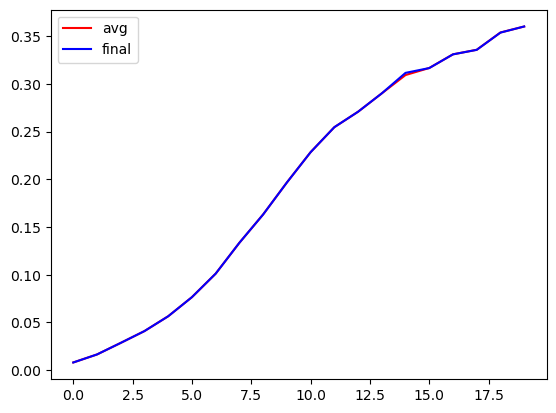

In [15]:
# Plotting eval accs and eval final accs
# plt.plot(eval_accs, label="avg", color="red")
# plt.plot(eval_final_accs, label="final", color="blue")
# plt.legend()
# plt.show()

In [16]:
# For testing only. Chomsky evaluation is done in run_chomsky_experiments.ipynb
# regret, total_accuracy, total_final_accuracy = evaluate_transformer_decoder(
#     chomsky_generator, params, utm_generator, num_batches=10, size=MODEL_SIZE
# )
# print(total_accuracy, total_final_accuracy)

Chomsky Task:  even_pairs
0.3698835 0.3698499
